<a href="https://colab.research.google.com/github/germanjke/StyleTransformerGANs/blob/master/StyleTransferGANs_demo_ru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Демонстратия генеративно-состязательных сетей (GANs) на задаче переноса стиля (Style Transfer)


## Загрузим всё необходимое



In [1]:
from IPython.display import clear_output

In [2]:
!git clone https://github.com/zhanghang1989/PyTorch-Multi-Style-Transfer  # сам репозиторий 
!cd /content/PyTorch-Multi-Style-Transfer/experiments/ 
!bash models/download_model.sh  # здесь находится предобученная модель
!bash /content/PyTorch-Multi-Style-Transfer/experiments/models/download_model.sh 
!wget -O 21styles.model https://www.dropbox.com/s/2iz8orqqubrfrpo/21styles.model?dl=1
!pip install torchfile
clear_output(wait=True)
print("Done!")

Done!


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import os
from PIL import Image
import gc

Пример контента


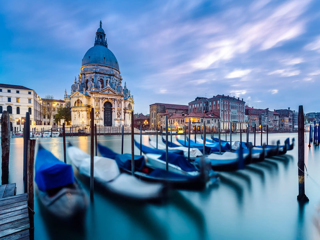

Пример стиля


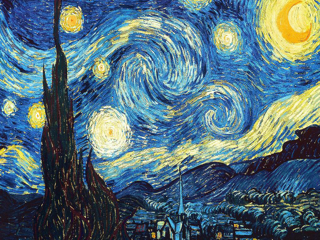

Пример того, что должно получиться


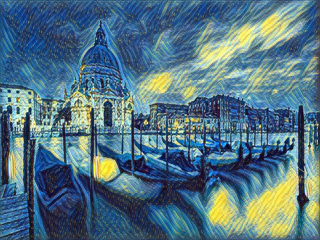

In [4]:
# Посмотрим на приемеры из репозитория
print('Пример контента')
display(Image.open('/content/PyTorch-Multi-Style-Transfer/experiments/images/content/venice-boat.jpg').resize((320,240)))
print('Пример стиля')
display(Image.open('/content/PyTorch-Multi-Style-Transfer/experiments/images/9styles/starry_night.jpg').resize((320,240)))
print('Пример того, что должно получиться')
display(Image.open('/content/PyTorch-Multi-Style-Transfer/images/3.jpg').resize((320,240)))

## Архитектура

In [8]:
class GramMatrix(nn.Module):
    """Define Gram Matrix."""
    def forward(self, y):
        (b, ch, h, w) = y.size()
        features = y.view(b, ch, w * h)
        features_t = features.transpose(1, 2)
        gram = features.bmm(features_t) / (ch * h * w)
        return gram


class Inspiration(nn.Module):
    """ Inspiration Layer (from MSG-Net paper)
    tuning the featuremap with target Gram Matrix
    ref https://arxiv.org/abs/1703.06953
    """
    def __init__(self, C, B=1):
        super(Inspiration, self).__init__()
        # B is equal to 1 or input mini_batch
        self.weight = nn.Parameter(torch.Tensor(1,C,C), requires_grad=True)
        # non-parameter buffer
        self.G = Variable(torch.Tensor(B,C,C), requires_grad=True)
        self.C = C
        self.reset_parameters()

    def reset_parameters(self):
        self.weight.data.uniform_(0.0, 0.02)

    def setTarget(self, target):
        self.G = target

    def forward(self, X):
        # input X is a 3D feature map
        self.P = torch.bmm(self.weight.expand_as(self.G),self.G)
        return torch.bmm(self.P.transpose(1,2).expand(X.size(0), self.C, self.C), X.view(X.size(0),X.size(1),-1)).view_as(X)

    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'N x ' + str(self.C) + ')'


# Some basic layers, with reflectance padding

class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = int(np.floor(kernel_size / 2))
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class UpsampleConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        if upsample:
            self.upsample_layer = torch.nn.Upsample(scale_factor=upsample)
        self.reflection_padding = int(np.floor(kernel_size / 2))
        if self.reflection_padding != 0:
            self.reflection_pad = nn.ReflectionPad2d(self.reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        if self.upsample:
            x = self.upsample_layer(x)
        if self.reflection_padding != 0:
            x = self.reflection_pad(x)
        out = self.conv2d(x)
        return out


class Bottleneck(nn.Module):
    """ Pre-activation residual block
    Identity Mapping in Deep Residual Networks
    ref https://arxiv.org/abs/1603.05027
    """
    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=nn.BatchNorm2d):
        super(Bottleneck, self).__init__()
        self.expansion = 4
        self.downsample = downsample
        if self.downsample is not None:
            self.residual_layer = nn.Conv2d(inplanes, planes * self.expansion,
                                                        kernel_size=1, stride=stride)
        conv_block = []
        conv_block += [norm_layer(inplanes),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, planes, kernel_size=1, stride=1)]
        conv_block += [norm_layer(planes),
                                    nn.ReLU(inplace=True),
                                    ConvLayer(planes, planes, kernel_size=3, stride=stride)]
        conv_block += [norm_layer(planes),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(planes, planes * self.expansion, kernel_size=1, stride=1)]
        self.conv_block = nn.Sequential(*conv_block)
        
    def forward(self, x):
        if self.downsample is not None:
            residual = self.residual_layer(x)
        else:
            residual = x
        return residual + self.conv_block(x)
    

class UpBottleneck(nn.Module):
    """ Up-sample residual block (from MSG-Net paper)
    Enables passing identity all the way through the generator
    ref https://arxiv.org/abs/1703.06953
    """
    def __init__(self, inplanes, planes, stride=2, norm_layer=nn.BatchNorm2d):
        super(UpBottleneck, self).__init__()
        self.expansion = 4
        self.residual_layer = UpsampleConvLayer(inplanes, planes * self.expansion,
                                                      kernel_size=1, stride=1, upsample=stride)
        conv_block = []
        conv_block += [norm_layer(inplanes),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, planes, kernel_size=1, stride=1)]
        conv_block += [norm_layer(planes),
                                    nn.ReLU(inplace=True),
                                    UpsampleConvLayer(planes, planes, kernel_size=3, stride=1, upsample=stride)]
        conv_block += [norm_layer(planes),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(planes, planes * self.expansion, kernel_size=1, stride=1)]
        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return  self.residual_layer(x) + self.conv_block(x)
        

class Net(nn.Module):
    """The MSG-Net."""
    def __init__(self, input_nc=3, output_nc=3, ngf=64, norm_layer=nn.InstanceNorm2d, n_blocks=6, gpu_ids=[]):
        super(Net, self).__init__()
        self.gpu_ids = gpu_ids
        self.gram = GramMatrix()

        block = Bottleneck
        upblock = UpBottleneck
        expansion = 4

        model1 = []
        model1 += [ConvLayer(input_nc, 64, kernel_size=7, stride=1),
                            norm_layer(64),
                            nn.ReLU(inplace=True),
                            block(64, 32, 2, 1, norm_layer),
                            block(32*expansion, ngf, 2, 1, norm_layer)]
        self.model1 = nn.Sequential(*model1)

        model = []
        self.ins = Inspiration(ngf*expansion)
        model += [self.model1]
        model += [self.ins]    

        for i in range(n_blocks):
            model += [block(ngf*expansion, ngf, 1, None, norm_layer)]
        
        model += [upblock(ngf*expansion, 32, 2, norm_layer),
                            upblock(32*expansion, 16, 2, norm_layer),
                            norm_layer(16*expansion),
                            nn.ReLU(inplace=True),
                            ConvLayer(16*expansion, output_nc, kernel_size=7, stride=1)]

        self.model = nn.Sequential(*model)

    def setTarget(self, Xs):
        F = self.model1(Xs)
        G = self.gram(F)
        self.ins.setTarget(G)

    def forward(self, input):
        return self.model(input)

## Utilities (вспомогательные функции)

In [5]:
def tensor_load_rgbimage(filename, size=None, scale=None, keep_asp=False):
    img = Image.open(filename).convert('RGB')
    if size is not None:
        if keep_asp:
            size2 = int(size * 1.0 / img.size[0] * img.size[1])
            img = img.resize((size, size2), Image.ANTIALIAS)
        else:
            img = img.resize((size, size), Image.ANTIALIAS)

    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    img = np.array(img).transpose(2, 0, 1)
    img = torch.from_numpy(img).float()
    return img


def tensor_save_rgbimage(tensor, filename, cuda=False):
    if cuda:
        img = tensor.clone().cpu().clamp(0, 255).numpy()
    else:
        img = tensor.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype('uint8')
    img = Image.fromarray(img)
    img.save(filename)


def tensor_save_bgrimage(tensor, filename, cuda=False):
    (b, g, r) = torch.chunk(tensor, 3)
    tensor = torch.cat((r, g, b))
    tensor_save_rgbimage(tensor, filename, cuda)
    
    
def preprocess_batch(batch):
    batch = batch.transpose(0, 1)
    (r, g, b) = torch.chunk(batch, 3)
    batch = torch.cat((b, g, r))
    batch = batch.transpose(0, 1)
    return batch

In [6]:
def transform(content_root, style_root, im_size, filename):
    """Function for image transformation."""
    content_image = tensor_load_rgbimage(content_root, size=im_size,
                                         keep_asp=True).unsqueeze(0)
    style = tensor_load_rgbimage(style_root, size=im_size).unsqueeze(0)
    style = preprocess_batch(style)
    style_v = Variable(style)
    content_image = Variable(preprocess_batch(content_image))
    style_model.setTarget(style_v)
    output = style_model(content_image)
    tensor_save_bgrimage(output.data[0], filename, False)

    # Clear the RAM.
    del content_image
    del style
    del style_v
    del output
    torch.cuda.empty_cache()
    gc.collect()

## Experiment

In [9]:
# Creating model and loading the weights.
style_model = Net(ngf=128)
style_model.load_state_dict(torch.load('/content/21styles.model'), False)
clear_output()

RuntimeError: ignored

In [10]:
# Checking architecture.
style_model

Net(
  (gram): GramMatrix()
  (model1): Sequential(
    (0): ConvLayer(
      (reflection_pad): ReflectionPad2d((3, 3, 3, 3))
      (conv2d): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    )
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): Bottleneck(
      (residual_layer): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
      (conv_block): Sequential(
        (0): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (3): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (4): ReLU(inplace=True)
        (5): ConvLayer(
          (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
          (conv2d): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
        )
        (6): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=Fals

# Проверим работу сети на примерах фотографий из интернета

In [11]:
# Загрузим несколько фотографий из интернета
!wget -O einstein.jpg https://miro.medium.com/max/3200/0*bd5gwXZGjRFGVRLD.jpeg
!wget -O sber.jpg https://pbs.twimg.com/profile_images/1309044913678487552/VyFIANEr_400x400.jpg
!wget -O ny.jpg https://frenchparis.ru/wp-content/uploads/frenchparis/2012/03/%D1%81%D1%82%D0%B0%D1%82%D1%83%D1%8F-%D1%81%D0%B2%D0%BE%D0%B1%D0%BE%D0%B4%D1%8B4.jpg
clear_output(wait=True)
print("Done!")

Done!


In [12]:
# Загрузим несколько стиля из интернета
!wget -O munk.jpg https://opisanie-kartin.com/uploads/image061.jpg
!wget -O shishkin.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Utro_v_sosnovom_lesu.jpg/399px-Utro_v_sosnovom_lesu.jpg
!wget -O dali.jpg https://artworld.ru/images/cms/content/catalog2/kartina_maslom_myagkie_chasy_v_moment_pervogo_vzryva_kopiya_kartiny_salvadora_dali_sd190701.jpg
clear_output(wait=True)
print("Done!")

Done!


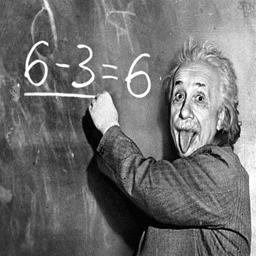

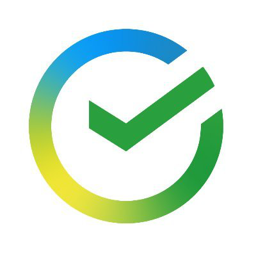

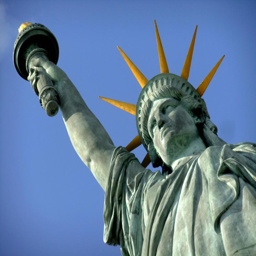

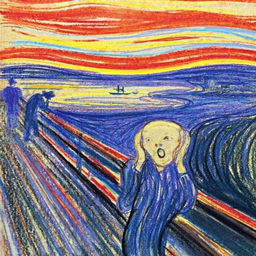

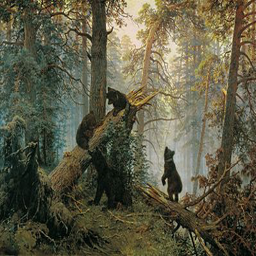

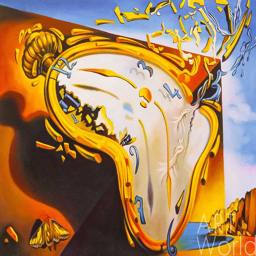

In [13]:
# Посмотрим что мы загрузили
display(Image.open('/content/einstein.jpg').resize((256, 256)))
print()
display(Image.open('/content/sber.jpg').resize((256, 256)))
print()
display(Image.open('/content/ny.jpg').resize((256, 256)))
print()
display(Image.open('/content/munk.jpg').resize((256, 256)))
print()
display(Image.open('/content/shishkin.jpg').resize((256, 256)))
print()
display(Image.open('/content/dali.jpg').resize((256, 256)))

In [14]:
# Now let's transform them.
transform("/content/einstein.jpg", "/content/munk.jpg", 256, "result1.jpg")
transform("/content/sber.jpg", "/content/shishkin.jpg", 256, "result2.jpg")
transform("/content/ny.jpg", "/content/dali.jpg", 256, "result3.jpg")

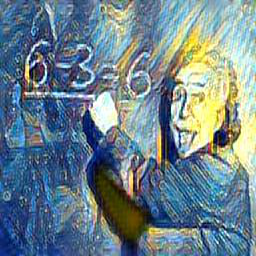

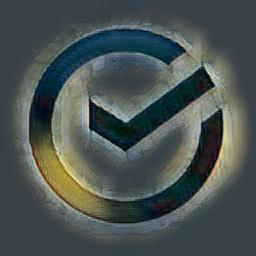

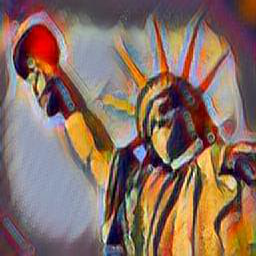

In [15]:
# Let's check the results.
display(Image.open('/content/result1.jpg').resize((256, 256)))
print()
display(Image.open('/content/result2.jpg').resize((256, 256)))
print()
display(Image.open('/content/result3.jpg').resize((256, 256)))

## Источники для более детального погружения в GANs

[Wikipedia](https://en.wikipedia.org/wiki/Generative_adversarial_network)  
[Video from YouTube](https://www.youtube.com/watch?v=8L11aMN5KY8) (popular science, express version, 21 minutes)  
[Seminar from YouTube](https://www.youtube.com/watch?v=u2HDm7YSwoA) (Deep Learning School's by MIPT version, detailed, 1 hour 50 minutes)  
[Code and abstract from the video above](https://github.com/DLSchool/deep_learning_2018-19/tree/master/14.%20GAN%20and%20Style%20transfer)  
[Article about GANs](https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29)  
[An overview paper](https://arxiv.org/abs/1710.07035)
